[![Open In Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/tushar-mahalya/Custom-ChatGPT/blob/master/data/reddit_data.ipynb)

# Data Acquisition
For our project we are going to use the wisdom of 3 most popular Reddit communities related to Data Science -
* Machine Learning - [r/MachineLearning](https://www.reddit.com/r/MachineLearning/)
* Artificial Intelligence - [r/artificial](https://www.reddit.com/r/Artificial/)
* Data Science - [r/DataScience](https://www.reddit.com/r/DataScience/)

We will extract the required information using Reddit's official API - [PRAW](https://praw.readthedocs.io/en/stable/code_overview/models/subreddit.html) (The Python Reddit API Wrapper).

In [1]:
# Importing important libraries
import os
import praw
import pandas as pd
import configparser
import datetime as dt

The credentials required to access API can be procured from [reddit.com/prefs/apps](https://www.reddit.com/prefs/apps).

For this project, I have saved my credentials in 'credentials.ini' file to protect my sensitive information.

In [3]:
# Creating read-only Reddit instance
reddit = praw.Reddit(user_agent = "slava",
                    client_id = "hTMoQIdSNjJhHS3R0hxQFg",
                    client_secret = "97YXZEUB3bsa2PWnnHc6_QJNrLkZ0Q")

## Extracting Top Posts
We will extract top 1000 post of all time from each sub-reddit to create our dataset along with some other useful information like Post URL (& ID), User posted, Post title, Flair, Number of Comments, Time Created, Upvote Ratio and Score.
We will use this information further to analyse and infer useful insights from it.

In [103]:
subreddits = ['talesfromthejob', 'AskReddit', 
              'booksuggestions', 'cscareerquestions', 
              'csMajors']
subreddit = '+'.join(subreddits) 

In [104]:
# Creating DataFrame of the top posts along with other attributes for analysis
posts = reddit.subreddit(subreddit).new(limit=100)
posts_list = []

for post in posts:
    posts_list.append({
        'post_id' : post.id,
        'post_title' : post.title,
        'post_body': post.selftext,
        'subreddit' : post.subreddit,
        'time_created' : post.created_utc,
        'post_url' : post.url,
        'flair_text' : post.link_flair_text,
        'score' : post.score,
        'comments' : post.num_comments,
        'upvote_ratio' : post.upvote_ratio
    })
    
posts_df = pd.DataFrame(posts_list)

In [105]:
# Converting UTC Date format to Standard Date-Time format
posts_df['date-time'] = posts_df['time_created'].apply(lambda x: dt.datetime.fromtimestamp(x))

# Dropping 'time_created' column
posts_df.drop('time_created', axis = 1, inplace = True)

In [106]:
from sklearn.model_selection import train_test_split
train_posts, test_posts = train_test_split(posts_df, test_size=0.2)

In [107]:
# Saving our posts data in .csv format
train_posts.to_csv("Top_Posts_Train.csv", header = True, index = False)
test_posts.to_csv("Top_Posts_Test.csv", header = True, index = False)

## Extracting Comments
Using 'post_id' of top posts we will further extract all comments. We will create a different dataset containing 'post_id' and 'comment' to create our textual dataset for training our large NLP model (GPT-3.5-turbo). We will also utilize this data to analyse the sentiment around different topics and recognizing emotions of the text.

In [108]:
# Creating DataFrame of all the comments available in the Top Posts

comments_list = []

for post_id in posts_df['post_id']:
    submission = reddit.submission(post_id)
    submission.comments.replace_more(limit = None)
    
    for comment in submission.comments.list():
        # i.e. only top-level comments
        if comment.parent_id == 't3_' + post_id:
            comments_list.append({
                'post_id' : post_id,
                'comment' : comment.body,
                'controversiality': comment.controversiality,
                'created_utc': comment.created_utc,
                'edited': comment.edited,
                'is_submitter': comment.is_submitter,
                'score': comment.score,
                'num_comments_below': len(comment.replies.list())
            })
        
comments_df = pd.DataFrame(comments_list)
comments_df['date-time'] = comments_df['created_utc'].apply(lambda x: dt.datetime.fromtimestamp(x))
comments_df.drop('created_utc', axis = 1, inplace = True)

In [109]:
train_comments = comments_df[comments_df.post_id.isin(train_posts['post_id'].tolist())]
train_comments.to_csv('Top_Posts_Comments_Train.csv', header = True, index = False)
test_comments = comments_df[comments_df.post_id.isin(test_posts['post_id'].tolist())]
test_comments.to_csv('Top_Posts_Comments_Test.csv', header = True, index = False)

In [110]:
from datasets import load_dataset, DatasetDict
print('Posts')
posts_train = load_dataset("csv", data_files="Top_Posts_Train.csv")["train"]
posts_test = load_dataset("csv", data_files="Top_Posts_Test.csv")["train"]
posts_ds = DatasetDict({"train": posts_train, "test": posts_test})
print('Comments')
comments_train = load_dataset("csv", data_files="Top_Posts_Comments_Train.csv")["train"]
comments_test = load_dataset("csv", data_files="Top_Posts_Comments_Test.csv")["train"]
comments_ds = DatasetDict({"train": comments_train, "test": comments_test})

Posts


Extracting data files: 100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 199.80it/s]


Dataset csv downloaded and prepared to /home/ummagumma/.cache/huggingface/datasets/csv/default-1b2af8acf96539fd/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 124.12it/s]


Extracting data files: 100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 338.28it/s]


Dataset csv downloaded and prepared to /home/ummagumma/.cache/huggingface/datasets/csv/default-7c968c223e6a4d97/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 160.65it/s]

Comments


Extracting data files: 100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 292.22it/s]


Dataset csv downloaded and prepared to /home/ummagumma/.cache/huggingface/datasets/csv/default-1c33a8bbeccb34f6/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 114.59it/s]


Extracting data files: 100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 543.23it/s]


Dataset csv downloaded and prepared to /home/ummagumma/.cache/huggingface/datasets/csv/default-877e941362185ba0/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 129.02it/s]


In [111]:
posts_ds

DatasetDict({
    train: Dataset({
        features: ['post_id', 'post_title', 'post_body', 'subreddit', 'post_url', 'flair_text', 'score', 'comments', 'upvote_ratio', 'date-time'],
        num_rows: 80
    })
    test: Dataset({
        features: ['post_id', 'post_title', 'post_body', 'subreddit', 'post_url', 'flair_text', 'score', 'comments', 'upvote_ratio', 'date-time'],
        num_rows: 20
    })
})

In [ ]:
posts_ds.push_to_hub('ummagumm-a/reddit_posts')
comments_ds.push_to_hub('ummagumm-a/reddit_posts_comments')


# Analysis

In [113]:
import pandas as pd
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
%matplotlib inline

In [122]:
sid_obj = SentimentIntensityAnalyzer()

def add_sentiment(doc):
    ans = sid_obj.polarity_scores(doc)
    
    keys = ['neg', 'neu', 'pos']
    values = [ans['neg'], ans['neu'], ans['pos']]
    
    return keys[np.argmax(values)]

In [123]:
post_df = pd.read_csv('Top_Posts_Train.csv')
comm_df = pd.read_csv('Top_Posts_Comments_Test.csv',
                 lineterminator='\n')
comm_df['edited'] = comm_df['edited'].astype(bool)
comm_df['controversiality'] = comm_df.controversiality.astype(bool)
comm_df['sentiment'] = comm_df['comment'].apply(add_sentiment)

display(comm_df[:3])
print(comm_df.shape)

,post_id,comment,controversiality,edited,is_submitter,score,num_comments_below,date-time,sentiment
0,13g7f7u,"I took one to the knee, it ended my adventurin...",False,True,False,1,0,2023-05-13 07:43:33,neu
1,13g7f7u,Depends on the tip.,False,True,False,1,0,2023-05-13 07:43:02,neu
2,13g7f7u,Not as painful as removing the arrow,False,True,False,1,0,2023-05-13 07:44:03,neu


(6850, 9)


How the authorship of the post affects user interest.

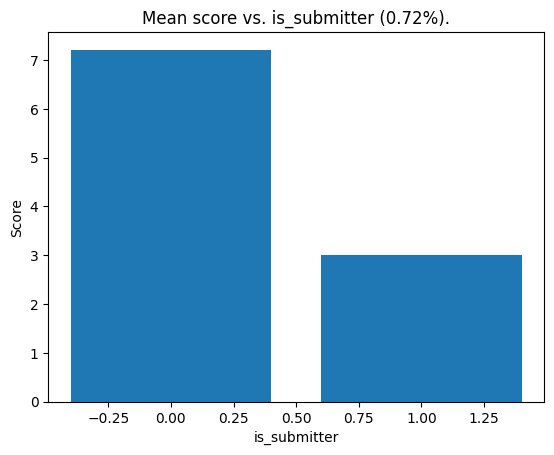

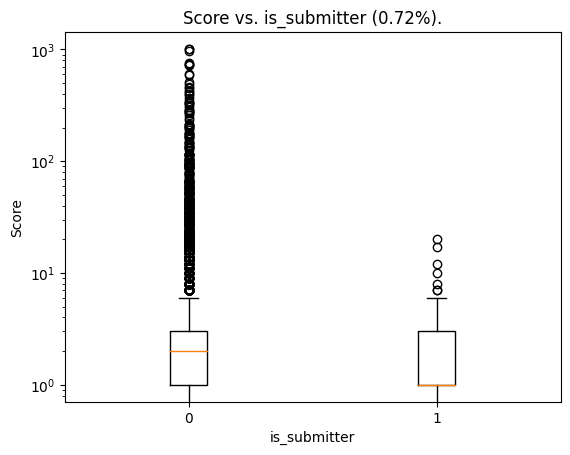

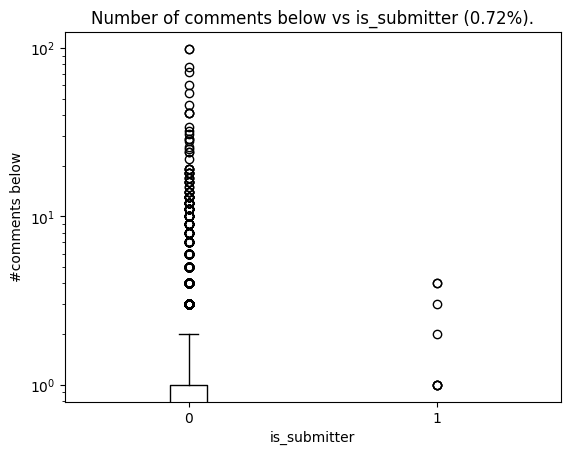

In [61]:
plt.bar([0, 1], [comm_df.score[~comm_df.is_submitter].mean(), 
                 comm_df.score[comm_df.is_submitter].mean()])
plt.title(f'Mean score vs. is_submitter ({round(comm_df.is_submitter.mean() * 100, 2)}%).')
plt.xlabel('is_submitter')
plt.ylabel('Score')
plt.show()

plt.boxplot([comm_df.score[~comm_df.is_submitter], 
             comm_df.score[comm_df.is_submitter]],
            positions=[0,1])
plt.title(f'Score vs. is_submitter ({round(comm_df.is_submitter.mean() * 100, 2)}%).')
plt.xlabel('is_submitter')
plt.ylabel('Score')
plt.yscale('log')
plt.show()

plt.boxplot([comm_df.num_comments_below[~comm_df.is_submitter], 
             comm_df.num_comments_below[comm_df.is_submitter]],
            positions=[0,1])
plt.title(f'Number of comments below vs is_submitter ({round(comm_df.is_submitter.mean() * 100, 2)}%).')
plt.xlabel('is_submitter')
plt.ylabel('#comments below')
plt.yscale('log')
plt.show()

How controversiality affects user interest.

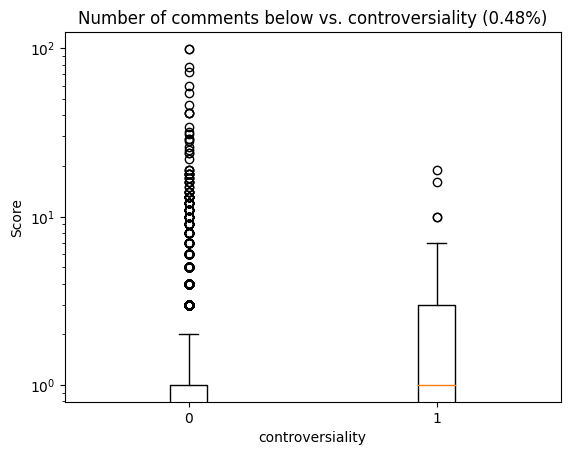

In [62]:
plt.boxplot([comm_df.num_comments_below[~comm_df.controversiality], 
             comm_df.num_comments_below[comm_df.controversiality]],
            positions=[0,1])
plt.title(f'Number of comments below vs. controversiality ({round(comm_df.controversiality.mean() * 100, 2)}%)')
plt.xlabel('controversiality')
plt.ylabel('Score')
plt.yscale('log')
plt.show()

Number of comments under each post.

In [80]:
post_df.comments.mean(), post_df.comments.median()

(14.671303451828955, 5.0)

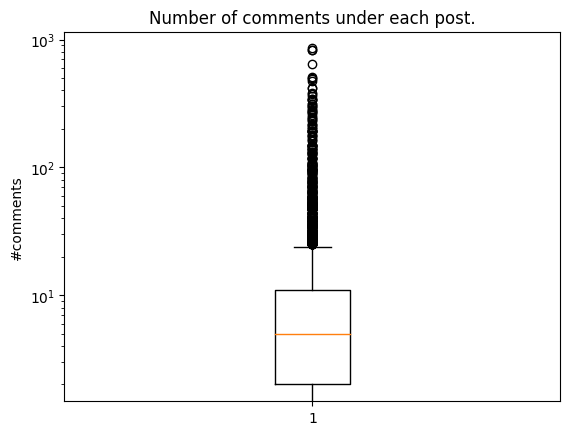

In [79]:
plt.boxplot(post_df.comments)
plt.title("Number of comments under each post.")
plt.yscale('log')
plt.ylabel('#comments')
plt.show()

Connection between score and the length of comment

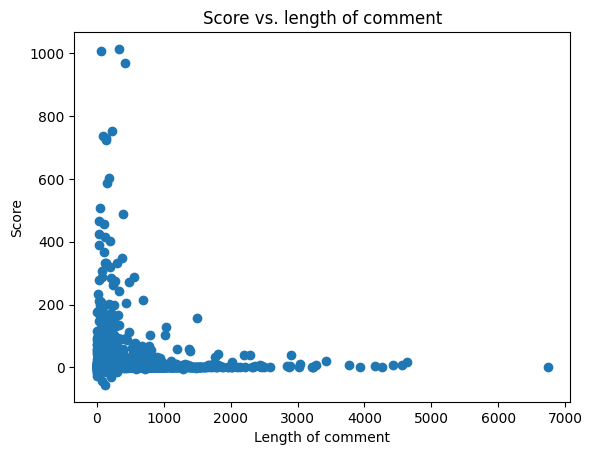

In [110]:
plt.scatter(l, s)
# plt.plot(a.index.tolist(), a.tolist(), c='r')
plt.title('Score vs. length of comment')
plt.ylabel('Score')
plt.xlabel('Length of comment')
plt.show()

Sentiment Analysis

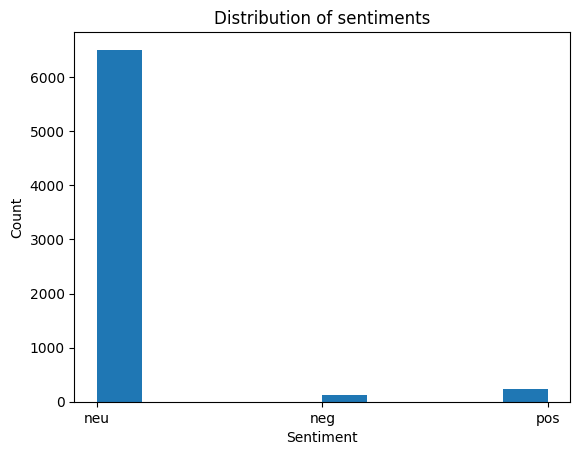

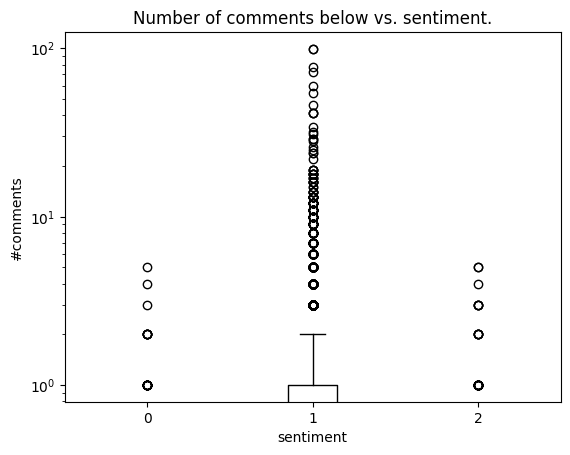

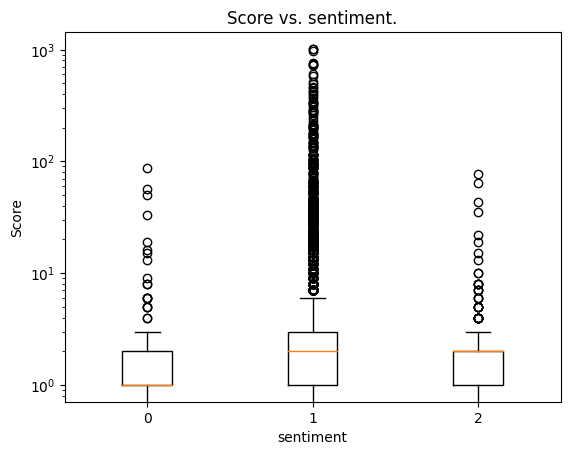

In [135]:
plt.hist(comm_df.sentiment)
plt.title("Distribution of sentiments")
plt.ylabel('Count')
plt.xlabel('Sentiment')
plt.show()

plt.boxplot([comm_df.num_comments_below[comm_df.sentiment == 'neg'], 
             comm_df.num_comments_below[comm_df.sentiment == 'neu'],
             comm_df.num_comments_below[comm_df.sentiment == 'pos']],
            positions=[0,1,2])
plt.title(f'Number of comments below vs. sentiment.')
plt.xlabel('sentiment')
plt.ylabel('#comments')
plt.yscale('log')
plt.show()

plt.boxplot([comm_df.score[comm_df.sentiment == 'neg'], 
             comm_df.score[comm_df.sentiment == 'neu'],
             comm_df.score[comm_df.sentiment == 'pos']],
            positions=[0,1,2])
plt.title(f'Score vs. sentiment.')
plt.xlabel('sentiment')
plt.ylabel('Score')
plt.yscale('log')
plt.show()